In [79]:
import numpy as np
import random
from gym.spaces import Discrete
import matplotlib.pyplot as plt
from matplotlib import pylab as plt
import pandas as pd

In [2]:
device = "cuda" if not torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


# Controles op een move

In [3]:
#Controleren of een move mag of niet
def legal_move(x,y,z,veld,size):
    
    #max hoogte
    if z > size[2] - 1:
        return False 
    
    #buiten lot
    if x < 0 or x >= size[0] or y < 0 or y >= size[1]:
        return False 
    
    #staat al een container
    if veld[x][y][z] != 0:
        return False
    
    #container zweeft niet
    if not veld[x][y][:z].all() != 0:
        return False 
    
    #container in het midden 
    if y-1 != -1 and y+1 != size[1]:
        if veld[x][y-1][0] != 0 and veld[x][y+1][0] != 0:
            return False 
    
    return True  

In [4]:
# De gekozen action omzetten naar een (x,y,z) coördinaat 
def action_number_to_xyz(action,size):
    waarde = action + 1
    
    #x-waarde vinden
    for a in range(size[0] + 1):
        if waarde <= a * (size[1] * size[2]):
            x = a - 1
            break 

    #y-waarde vinden
    waarde_y = waarde - (x * size[1] * size[2])

    for i in range(waarde_y + 1):
        if waarde_y <= i * (size[2]):
            y = i - 1
            break
    
    #z-waarde berekenen
    z = waarde_y - y * size[2] - 1

    return x,y,z

In [5]:
#container in de matrix neerzetten met de prioriteit
def place_container(action, prio, speelveld,size):

    x,y,z = action_number_to_xyz(action,size)
   
    if legal_move(x,y,z,speelveld,size):
        speelveld[x][y][z] = prio
        return True, speelveld
    else:
        return False, speelveld

# Environment en agent

In [21]:
class Environment():

    def __init__(self,size):
        #action_space en observation_space aanmaken
        self.size = size
        self.action_space = Discrete(int(self.size[0]*self.size[1]*self.size[2]))
        self.observation_space = speelveld.flatten()
        self.state = self.reset()
        self.poging = 0

    def step(self,action,prio):
        
        #container plaatsen
        if type(self.state) == tuple:
            self.state = self.state[1]
        
        iets = place_container(action,prio,self.state.reshape(self.size),self.size)
        
        # reward
        if iets[0]:
            reward = 1
            self.poging = 0 
        else:
            reward = -1
            self.poging += 1    
        if (self.state == 0).sum() == 0:
            reward += 10
        
        #state en reward doorgeven
        self.state = iets[1].flatten()
        return self.state.astype(int), reward, self.state

    def reset(self):
        self.state = np.array([([( [[0] * self.size[2]]) * self.size[1] ]) * self.size[0] ]).astype(object).flatten()
        self.reward = 0
        self.poging = 0
        return self.reward, self.state

    def game_over(self):
        
        #alle containers geplaatst of niet mogelijk container plaatsen 
        aantal_nul = (self.state == 0).sum()

        if aantal_nul == 0 or self.poging >= int(self.size[0]*self.size[1]*self.size[2]) or self.poging >= aantal_nul:
            return True
        return False
    
    def state_(self):
        return self.state
    def action_state_(self):
        return self.action_space

In [22]:
class myAgent():
    def __init__(self, env):
        self.total_rewards = 0
        self.env = env
        
    def steps(self,action):   
        
        #actie uitvoeren
        actie = self.env.step(action , 1)  
        
        #reward krijgen 
        self.total_rewards += actie[1]
        return actie
    
    def reset(self):
        self.total_rewards = 0
        return self.total_rewards
    
    def game_reward(self):
        return self.total_rewards

# Q-learning

In [113]:
def train(gamma,learning_rate,num_of_episodes,agent,enviroment,plot):

    size = (3,3,1)
    reward_game = 0
    game_scores = []
    stappen = []
    q_table = np.zeros([containers, containers], dtype=int)

    for episode in range(0, num_of_episodes):
        
        # Environment en agent resetten
        state = enviroment.reset()[1]
        agent.reset()
        reward = 0
        agent.reset()

        while not enviroment.game_over():
            state = enviroment.state_().astype(int)

            # Stap kiezen en uitvoeren
            if random.uniform(0, 1) < epsilon:
                action = enviroment.action_space.sample()
            else:
                action = np.argmax(q_table[state])

            stappen.append(action) 
            next_state, reward, iets = agent.steps(action)

            # Q table updaten
            q_value = q_table[state, action]
            max_value = np.max(q_table[next_state])
            new_q_value = (1 - learning_rate) * q_value + learning_rate * (reward + gamma * max_value)    
            q_table[state, action] = new_q_value
            state = next_state
        
        
        game_rewards = agent.game_reward()
        game_scores.append(game_rewards)
    
    if plot == True:
        median_scores= []
        max_scores= []
        min_scores= []

        #data opdelen voor een duidelijkere grafiek 
        chunks = [game_scores[x:x+100] for x in range(0, len(game_scores), 100)]
        for i in chunks:
            #de median, min en max bepalen
            median_scores.append(np.median(i))
            max_scores.append(max(i))
            min_scores.append(min(i))
        x = [i*100 for i in range(int(num_of_episodes/100))]

        #plot maken en laten zien
        plt.plot(x,max_scores, label= "Maximum")
        plt.plot(x,median_scores, label = "Mediaan")
        plt.plot(x,min_scores, label = "Minimum")
        plt.axhline(y=19, color='r', linestyle='--', label="Maximale score")
        plt.title("Scores 3x3x1")
        plt.xlabel("Games")
        plt.ylabel("Score")
        plt.legend()
        plt.show()
    
    return np.mean(game_scores[-500:]),np.median(game_scores[-500:])

# Learning rate en gamma bepalen met Grid Search

In [104]:
lijst_lr = [0.1,0.2,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9]
mean = []
median = []

#Model trainen met verschillende learning rates
for i in lijst_lr:
    gamma = 0.9
    learning_rate = i
    num_of_episodes = 10000
    epsilon = 1
    containers = size[0]*size[1]*size[2]
    speelveld = np.array([([( [[0] * size[2]]) * size[1] ]) * size[0] ]).astype(object)
    enviroment = Environment(size)
    agent = myAgent(enviroment)
    enviroment.reset()
    
    #resultaten opslaan
    a,b = train(gamma,learning_rate,num_of_episodes,agent,enviroment, False)
    mean.append(a)
    median.append(b)

#Resultaten in Dataframe zetten
pd.DataFrame(list(zip(lijst,mean,median)),columns =['Learning rate', 'mean','median'])

,Learning rate,mean,median
0,1.000000e-01,0.760,1.0
1,2.000000e-01,0.678,1.0
2,1.000000e-02,0.720,1.0
3,1.000000e-03,1.214,1.0
4,1.000000e-04,0.768,1.0
5,1.000000e-05,0.846,1.0
6,1.000000e-06,0.774,1.0
7,1.000000e-07,0.890,1.0
8,1.000000e-08,0.916,1.0
9,1.000000e-09,0.736,1.0


In [91]:
lijst_gamma = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
mean = []
median = []

#model trainen met verschillende gammas
for i in lijst_gamma:
    gamma = i
    learning_rate = 1e-4
    num_of_episodes = 5000
    epsilon = 1
    containers = size[0]*size[1]*size[2]
    speelveld = np.array([([( [[0] * size[2]]) * size[1] ]) * size[0] ]).astype(object)
    enviroment = Environment(size)
    agent = myAgent(enviroment)
    enviroment.reset()
    
    #resultaten opslaan
    a,b = train(gamma,learning_rate,num_of_episodes,agent,enviroment, False)
    mean.append(a)
    median.append(b)

#Resultaten in Dataframe zetten
pd.DataFrame(list(zip(lijst,mean,median)),columns =['Learning rate', 'mean','median'])

,Learning rate,mean,median
0,0.1,0.966,1.0
1,0.2,0.968,1.0
2,0.3,0.664,1.0
3,0.4,0.992,1.0
4,0.5,0.942,1.0
5,0.6,0.598,1.0
6,0.7,1.010,1.0
7,0.8,0.996,1.0
8,0.9,0.816,1.0


# Uiteindelijke resultaat plotten

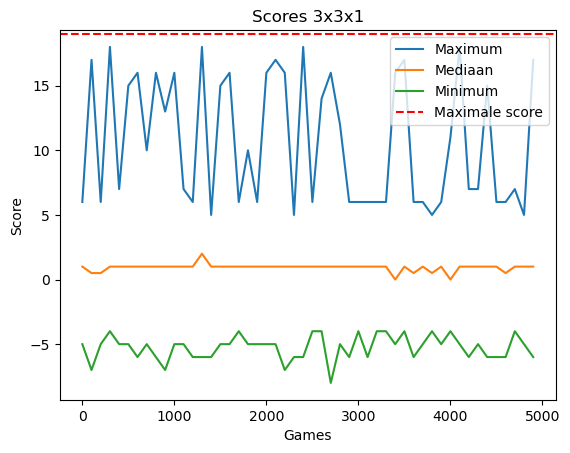

(0.81, 1.0)

In [114]:
containers = size[0]*size[1]*size[2]
speelveld = np.array([([( [[0] * size[2]]) * size[1] ]) * size[0] ]).astype(object)
enviroment = Environment(size)
agent = myAgent(enviroment)
enviroment.reset()
train(0.7, 1e-4,5000, agent, enviroment, True)
